# CS-E5740 Complex Networks,
Answers to exercise set 5 <br>
Adam Ilyas 725819

In [1]:
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import networkx as nx

from utils import add_colorbar
from utils import visualize_network

# PageRank (directed network)

### a) Load the network given in file `pagerank_network.edg` and, as a sanity check, visualize it with nx.draw.

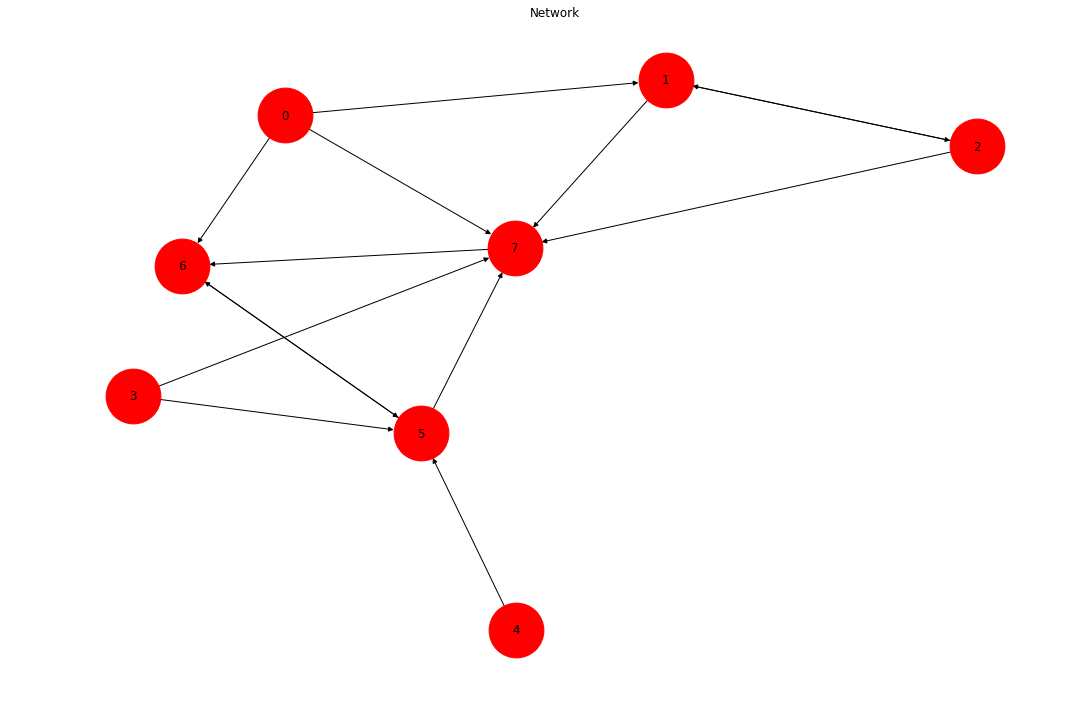

In [2]:
#TODO: replace, set the correct path to the network
network_path = './data/pagerank_network.edg'

network =  nx.read_edgelist(network_path, create_using=nx.DiGraph())

# Visualization of the network (note that spring_layout
# is intended to be used with undirected networks):
node_positions = nx.spring_layout(network.to_undirected())
cmap = 'OrRd'
node_size = 3000

fig=visualize_network(network, node_positions, 
                      cmap=cmap, node_size=node_size, title="Network")

# fig.savefig('./network_visualization.pdf')

### b) Write a function that computes the PageRank on a network by simulating a random walker. 
In more detail,

`d` : damping factor of the simulation
`n_steps` : number of steps of the random walker

The random walker teleports to a random node with
probability `1-d` and with probability `d` picks one of the neighbors of the
current node.

Random walker steps, at each step:
- Increase the PageRank of current node by 1
- Check if the random walker will teleport or go to a neighbor
- Pick the next node either randomly or from the neighbors
- Update the current node variable to point to the next node

In [3]:
def pageRank(network, d, n_steps):
    
    # Initializing PageRank dictionary:
    nodes = list(network.nodes())
    n_nodes = len(nodes)

    # Initialize PageRank of each node to 0
    pageRank = dict.fromkeys(nodes, 0)

    # Pick a random starting point for the random walker
    randomWalker = np.random.choice(a = nodes)

    for _ in range(n_steps):
        pageRank[randomWalker] += 1
        prob = np.random.rand()
        # Check if the random walker will teleport or go to a neighbor
        if prob > d: # teleport to random node
            randomWalker = np.random.choice(nodes)
        else: # pick neighbours
            randomWalker = np.random.choice(list(nx.neighbors(network, randomWalker)))

    for keys in pageRank:
        pageRank[keys] /= n_steps
    # 5) Normalize PageRank by n_steps
    return pageRank

In [4]:
nodes = list(network.node)
n_nodes = len(nodes)

n_steps = 10000
d = 0.85
pageRank_rw = pageRank(network, d, n_steps)

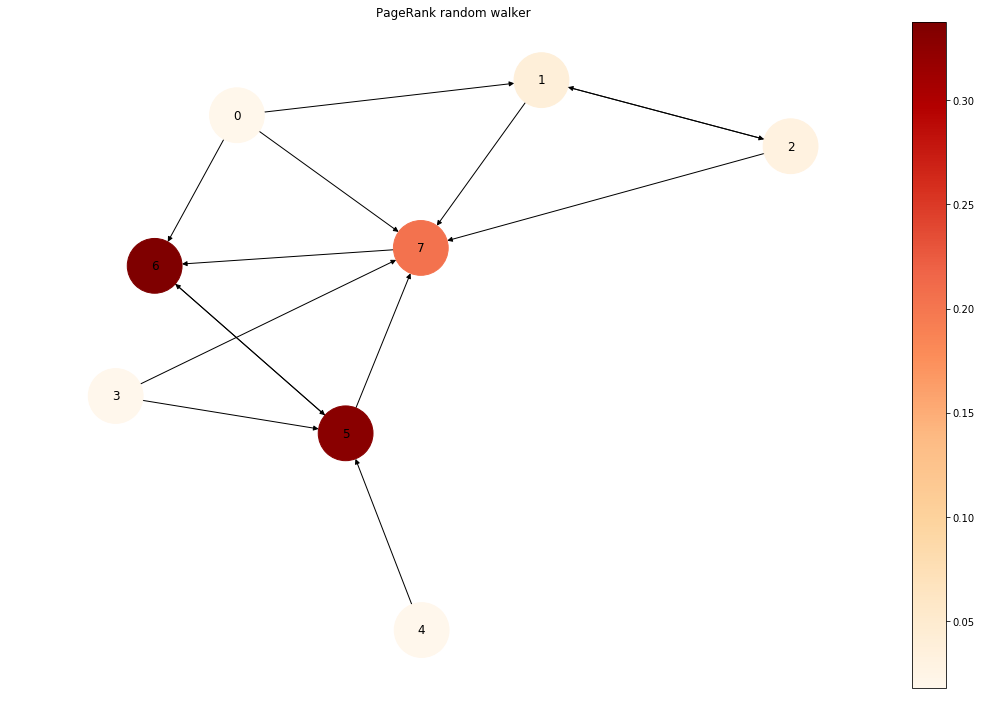

In [5]:
node_colors = [pageRank_rw[node] for node in nodes]
fig = visualize_network(network, node_positions, cmap=cmap, node_size=node_size,
                        node_colors=node_colors, title="PageRank random walker")

**Use your function to compute PageRank** in the example network. Visualize the
result on the network: update your visualization from a) by using the PageRank values
as node color values. 

Compare your results with `nx.pagerank` by plotting both results as
a function of node index.

`networkx.pagerank` function uses `d = 0.85`

In [6]:
pageRank_nx = nx.pagerank(network)
pageRank_nx

{'0': 0.018750000000000003,
 '1': 0.039092296060886114,
 '6': 0.3368382378354585,
 '7': 0.203486190698039,
 '2': 0.03536422597536588,
 '3': 0.018750000000000003,
 '5': 0.3289690494302504,
 '4': 0.018750000000000003}

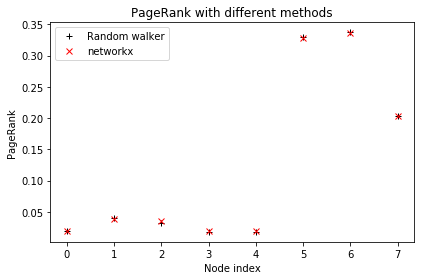

In [7]:
# Visualization to check that results from own function and nx.pagerank match:

pageRank_rw_array = np.zeros(n_nodes)
pageRank_nx_array = np.zeros(n_nodes)
for node in nodes:
    pageRank_rw_array[int(node)] = pageRank_rw[node]
    pageRank_nx_array[int(node)] = pageRank_nx[node]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(0, n_nodes), pageRank_rw_array, 'k+', label=r'Random walker')
plt.plot(range(0, n_nodes), pageRank_nx_array, 'rx', label='networkx')
ax.set_xlabel(r'Node index')
ax.set_ylabel(r'PageRank')
ax.set_title(r'PageRank with different methods')
ax.legend(loc=0)
plt.tight_layout()

The above algorithm is a naive way of computing PageRank.  The actual algorithm
behind the success of Google, introduced by its founders, Larry Page and Sergey Brin,
is based on power iteration

The power iteration can be shown to find the leading
eigenvector for the “Google matrix” (or other matrices) very fast under certain conditions.

An intuitive way of thinking about the power iteration algorithm is to think that at time
$t - 1$ you have a vector $x(t - 1)$ where each element gives the probability of finding the
walker.

You use the rules of the random walk/teleportation process to find out what are
the probabilities of finding the random walkers at each node at time $t$. That is you increase
the time $t$ and calculate $x(t)$ based on $x(t − 1)$ until the vector $x$ doesn’t change any more.

### c) Write a function that computes the PageRank by using power iteration. 
In more detail,

1. Initialize the PageRank of all nodes to $\frac{1}{n}$ , where $n$ is the number of nodes in the
network. That is, at the iteration $t = 0$ your PageRank vector contains the same
value for each node, and it is equally likely to find the walker in each node. 
<br >(Any
other initialization strategy is possible as long as the sum of all elements is one, and
the closer the initial vector is to the final vector the faster you will find the final
PageRank values.)
2. Increase the iteration number $t$ by one and create a new empty PageRank vector $x(t)$.
3. Fill in each element of the new vector PageRank vector $x(t)$ using the old PageRank
vector $x(t − 1)$ and the formula: $$x_i(t) = (1-d)\frac{1}{n} + d \sum_{j \in v_i} 
\frac{x_j(t-1)}{k_j^{out}}$$
**where $v_i$ is the set of nodes that have a directed link ending at $i$**, meaning $v_i$ are i's neighbours with edges ($v_i$, i)<br>and for each such node $j \in v_i, k_j^{out}$ is j's out degree.

In summary, for each node i you need to calculate their entry in
the new PageRank vector $x(t)$ as a sum of two parts:
- probability that the walker will teleport into the node $(1 − d) \frac{1}{n}$
- probability that the walker will move from a neighbor j to node i:

Iterate over each in-neighbor j of the node i (i.e., there is a link from i to j) and add the neighbors contribution
$d \frac{x_j(t-1)}{k_j^{out}}$ to the entry of the node i in the new PageRank
j
vector x(t).
4. repeat 2-3 N_{iterations} times

In [8]:
def pagerank_poweriter(g, d, iterations, output=True):

    nodes = list(g.node)
    n_nodes = len(nodes)

    # 1) Create a PageRank dictionary and initialize the PageRank of each node
    #    to 1/n where n is the number of nodes.
    pageRankDic = dict.fromkeys(nodes, 1/n_nodes)

    # 2) For each node i, find nodes having directed link to i and calculate
    #    sum(x_j(t-1)/k_j^out) where the sum is across the node's neighbors
    #    and x_j(t-1) is the PageRank of node

    for _ in range(iterations):
        pr_old = pageRankDic.copy()

        for i in nodes:
            in_edges = g.in_edges(i)
            if len(in_edges) != 0:
                neighbours = [edge[0] for edge in in_edges]
                neighbours_contribution = sum(
                    [pageRankDic[j] / g.out_degree(j) for j in neighbours]
                )
            else:
                neighbours_contribution = 0

            # Update each node's PageRank to (1-d)*1/n + d*sum(x_j(t-1)/k_j^out).          
            pageRankDic[i] = (1-d)/n_nodes + d * neighbours_contribution

        # sanity checks in each itteration:
        if output:
            print(f'PageRank sums to {sum(pageRankDic.values())}')
            print(f'PageRank difference since last iteration:') 
            print(f'{sum([abs(pageRankDic[i]-pr_old[i]) for i in g])}')
    return pageRankDic

PageRank sums to 0.8735625
PageRank difference since last iteration:
0.753578125
PageRank sums to 0.9911239746093752
PageRank difference since last iteration:
0.24648821289062506
PageRank sums to 0.9858023475891113
PageRank difference since last iteration:
0.01884626080322268
PageRank sums to 0.9912799827689858
PageRank difference since last iteration:
0.012863952886547118
PageRank sums to 0.9923339743837152
PageRank difference since last iteration:
0.0020033336768188054
PageRank sums to 0.9945248167399818
PageRank difference since last iteration:
0.0024632341109747935
PageRank sums to 0.9956630399870341
PageRank difference since last iteration:
0.0011553268329692196
PageRank sums to 0.9967511283548613
PageRank difference since last iteration:
0.001091177703033623
PageRank sums to 0.9974944609098277
PageRank difference since last iteration:
0.000743890566138182
PageRank sums to 0.9980972372937353
PageRank difference since last iteration:
0.0006028771746754494


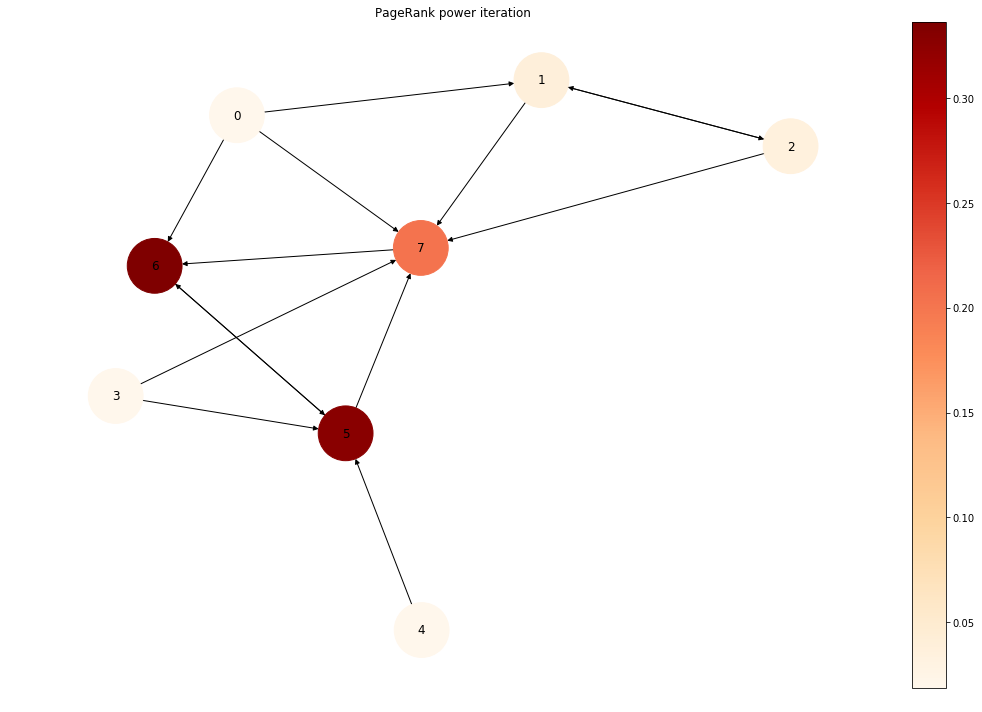

In [9]:
# PageRank with power iteration
n_iterations = 10
pageRank_pi = pagerank_poweriter(network, d, n_iterations)

# Visualization of PageRank by power iteration

node_colors = [pageRank_pi[node] for node in nodes]
fig = visualize_network(network, node_positions, 
                        cmap=cmap, 
                        node_size=node_size,
                        node_colors=node_colors, 
                        title="PageRank power iteration")

The Google search engine indexes billions of websites and the algorithm for calcu-
lating the PageRank needs to be extremely fast. In the original paper about PageRank
by Google founders Larry Page and Sergey Brin, they claim that their “iterative algorithm”
is able to calculate the PageRank for 26 million webpages in a few hours using a normal
desktop computer (in 1998). 



### c) Come up with a rough estimate of how long it would take for your power iteration algorithm (part c) and naive random walker algorithm (part b) to do the same. 

- You can assume that the average degree of the 26 million node network
is small and that the power iteration converges in the same number of steps as it does
for your smaller networks. 

- For the random walk you can assume that you need to run
enough steps that the walker visits each node on average 1000 times. 

You can also omit
any considerations of fitting the large network in memory or the time it takes to read it
from the disk etc. With these assumption you can simply calculate the time it takes to
run the algorithm in a reasonable size network and multiply the result by the factor that
the 26 million node network is bigger than your reasonable sized network.

In [10]:
# Investigating the running time of the power iteration fuction
num_tests = 3
def k5net(power=4):
    return nx.directed_configuration_model(in_degree_sequence=10**power*[5], 
                                    out_degree_sequence=10**power*[5],
                                    create_using=nx.DiGraph())
# TODO: Print results: how many seconds were taken for the test network of
# 10**4 nodes, how many hours would a 26*10**6 nodes network take?

In [11]:
for i in range(1, 5):
    net = k5net(power=i)
    print(f'No. of nodes: {10**i}')
    %timeit pagerank_poweriter(net, d=0.85, iterations=10, output=False)

No. of nodes: 10
1.44 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
No. of nodes: 100
13.6 ms ± 576 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
No. of nodes: 1000
158 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
No. of nodes: 10000
1.72 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
net = k5net(power=4)
%timeit pagerank_poweriter(net, d=0.85, iterations=10, output=False)

1.54 s ± 94.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
t = 2.59
n_nodes = 10**4
target = 26*10**6

print(f'Time for {target} nodes: {t/n_nodes*target /3600} hours')

Time for 26000000 nodes: 1.8705555555555555 hours


In [14]:
#%timeit pageRank(network=net, d=0.85, n_steps=1000*n_nodes)

### e) Describe how the network’s structure relates to PageRank. 
What is the connection
between degree $k$ or in-degree $k_{in}$ and PageRank? How does PageRank change if the
node belongs to a strongly connected component? How could this information be used in
improving the power iteration algorithm given in part c)?

**Ans** There is low connection between the degree $k$ of the node and it's page rank. It is the in-degree $k_{in}$
that matters: with more in-degree, there is greater neighbour contribution thus, the pagerank of that particular node will increase faster after each iteration.

If the node belongs to a strongly connected component, the neighbour contributions will be lessen as the degree of the node's neighbour will be higher. Intuitively, we can view this as the pagerank being spread around in the SCC, and the chances the one particular node lies on a shortest path is lesser (since we can likely find another path from the nodes in the SCC)

We can initialize our page rank of each nodes to a value proportionate to it's in-degree and whether it belongs to a SCC.

### f) Investigate the role of the damping factor `d`. 
Repeat the PageRank calculation
with e.g. 5 different values of $d \in [0, 1]$ and plot the PageRank as a function of node index
(plots of all values of d in the same figure). How does the change of d affect the rank of
the nodes and the absolute PageRank values?

In [15]:
def investigate_d(network, ds, colors, n_steps):
    """
    Calculates PageRank at different values of the damping factor d and
    visualizes and saves results for interpretation

    Parameters
    ----------
    network : a NetworkX graph object
    ds : a list of d values
    colors : visualization color for PageRank at each d, 
             must have same length as ds
    n_steps : int; number of steps taken in random walker algorithm
    """
    #import pdb; pdb.set_trace()
    nodes = network.nodes()
    n_nodes = len(network.nodes())
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
        
    for i in range(len(ds)):
        current_d = ds[i]
        current_colour = colors[i]
        pr = pageRank(network = network, d = current_d, n_steps = n_steps)
        
        current_plot = np.zeros(n_nodes)
        for node in pr:
            pr_value = pr[node] 
            current_plot[int(node)] = pr_value
        plt.plot(current_plot, label=np.round(current_d, 2), color=current_colour)
    
    ax.set_xlabel(r'Node index')
    ax.set_ylabel(r'PageRank')
    ax.set_title(r'PageRank with different damping factors')

    ax.legend(loc=0)
    plt.tight_layout

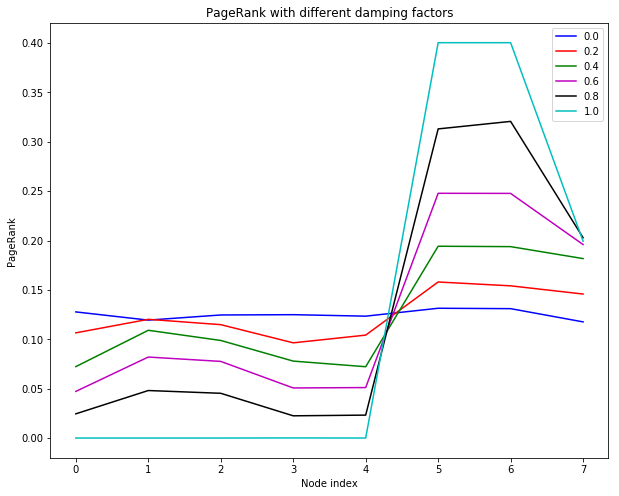

In [16]:
# Investigating effects of d:
ds = np.arange(0, 1.2, 0.2)
colors = ['b', 'r', 'g', 'm', 'k', 'c']

investigate_d(network=network, ds=ds, colors=colors, n_steps=10000)

Now, let’s see how PageRank works in a real network. File wikipedia_network.edg
contains the strongly connected component of the Wikipedia hyperlink network around
the page Network Science 1 . 

### g) Load the network and list the five most central nodes and their centrality score in terms of 
- PageRank, 
- in-degree, and 
- out-degree.

Here
you should use `nx.pagerank`, as the naive algorithm implemented in (a) converges very
slowly for a network of this size. Comment and interpret the differences and similarities
between the three lists of most central pages.

In [17]:
network_path_wp = './data/wikipedia_network.edg'
network_wp = nx.read_edgelist(network_path_wp, create_using=nx.DiGraph())

pageRank_wp = dict(nx.pagerank(network_wp))
indegree_wp = dict(network_wp.in_degree())
outdegree_wp = dict(network_wp.out_degree())
if pageRank_wp is not {}:
    highest_pr = sorted(pageRank_wp, key=lambda k: pageRank_wp[k])[::-1][0:5]
    print('---Highest PageRank:---')
    for p in highest_pr:
        print(pageRank_wp[p], ":", p)
if indegree_wp is not {}:
    highest_id = sorted(indegree_wp, key=lambda k: indegree_wp[k])[::-1][0:5]
    print('---Highest In-degree:---')
    for p in highest_id:
        print(indegree_wp[p], ":", p)
if outdegree_wp is not {}:
    highest_od = sorted(outdegree_wp, key=lambda k: outdegree_wp[k])[::-1][0:5]
    print('---Highest Out-degree:---')
    for p in highest_od:
        print(outdegree_wp[p], ":", p)


---Highest PageRank:---
0.03519319071432259 : Graph_theory
0.02036135061984469 : Social_network
0.016771511398301818 : Mathematics
0.016462083632076074 : Social_network_analysis
0.014703296264824403 : Social_networking_service
---Highest In-degree:---
82 : Social_network
73 : Social_network_analysis
63 : Small_world_experiment
62 : Social_networking_service
62 : Orkut
---Highest Out-degree:---
140 : Network_science
82 : Social_network
73 : Social_network_analysis
67 : Small-world_network
65 : Small_world_experiment
